## Heart Stroke Prediction using Pyspark in Google Cloud Platform

As a preliminary step , I created Clusters using Google DataProc and activated JupyterLab and Anaconda as Components 

In [1]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession

from pyspark.sql import SQLContext
from pyspark.sql import DataFrameNaFunctions

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer,Binarizer,VectorAssembler
from pyspark.sql.types import StructType ,StructField,IntegerType,DoubleType

from pyspark.ml.classification import LogisticRegression,NaiveBayes,RandomForestClassifier

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

#### Create a Spark Session

In [2]:
sc = SparkContext.getOrCreate()

In [3]:
sc

<SparkContext master=yarn appName=PySparkShell>

In [4]:
spark = SparkSession(sc)

In [5]:
df = spark.read.csv('gs://stroke-dataset/train_2v.csv',header = True)
df.show()

+-----+------+---+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender|age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+---+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|30669|  Male|  3|           0|            0|          No|     children|         Rural|            95.12|  18|           null|     0|
|30468|  Male| 58|           1|            0|         Yes|      Private|         Urban|            87.96|39.2|   never smoked|     0|
|16523|Female|  8|           0|            0|          No|      Private|         Urban|           110.89|17.6|           null|     0|
|56543|Female| 70|           0|            0|         Yes|      Private|         Rural|            69.04|35.9|formerly smoked|     0|
|46136|  Male| 14|           0|            0|          No| Nev

In [6]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- hypertension: string (nullable = true)
 |-- heart_disease: string (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: string (nullable = true)
 |-- bmi: string (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: string (nullable = true)



In [7]:
# def cast_datatypes(df):
df = df.withColumn('stroke',df['stroke'].cast(IntegerType()))
#     df = df.withColumn('gender',df['gender'].cast(IntegerType()))
#     df = df.withColumn('age',df['age'].cast(IntegerType()))
#     df = df.withColumn('hypertension',df['hypertension'].cast(IntegerType()))
#     df = df.withColumn('avg_glucose_level',df['avg_glucose_level'].cast(IntegerType()))
#     df = df.withColumn('bmi',df['bmi'].cast(IntegerType()))    
#     return df
# df = cast_datatypes(df)
# df.printSchema()

In [8]:
balance = df.groupby('stroke').count().collect()
categories = [category[0] for category in balance]
counts  = [count[1] for count in balance]
print(categories)
print(counts)
print(balance)

[1, 0]
[783, 42617]
[Row(stroke=1, count=783), Row(stroke=0, count=42617)]


#### Check the balance of the dataset

In [9]:
def check_dataset_balance(df):
    balance = df.groupby('stroke').count().collect()
    categories = [row[0] for row in balance]
    counts  = [row[1] for row in balance]
    ind = np.array(range(len(categories)))
    ind[:] = ind[::-1]
    width = 0.35
    plt.bar(ind, counts, width=width, color='r')

    plt.ylabel('counts')
    plt.title('Stroke')
    plt.xticks(ind)

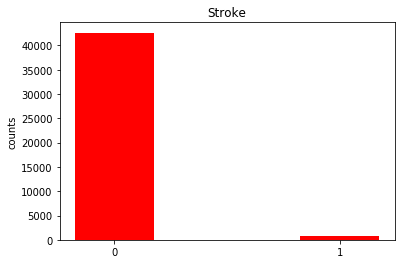

In [10]:
check_dataset_balance(df)

As we can see the dataset is highly imbalanced, I will try to oversample the class label __'1'__ using SMOTE

In [11]:
df.select("smoking_status").distinct().show()

+---------------+
| smoking_status|
+---------------+
|           null|
|         smokes|
|   never smoked|
|formerly smoked|
+---------------+



In [12]:
df.count()

43400

In [13]:
df = df.dropna()
df.count()

29072

In [14]:
df = df.withColumn('age',df['age'].cast(IntegerType()))
df = df.withColumn('hypertension',df['hypertension'].cast(IntegerType()))
df = df.withColumn('avg_glucose_level',df['avg_glucose_level'].cast(IntegerType()))
df = df.withColumn('heart_disease',df['heart_disease'].cast(IntegerType()))
df = df.withColumn('bmi',df['bmi'].cast(IntegerType()))    

Checking the balance after removing NaN values

In [15]:
# smoke_indexer = StringIndexer(inputCol='smoking_status',outputCol='smoking_status_category')
# gender_indexer = StringIndexer(inputCol='gender',outputCol='gender_category')
# featureColumns = ['age','hypertension','heart_disease','avg_glucose_level','bmi','smoking_status_category','gender_category']


#### Oversampling using SMOTE

In [16]:
# Filter features and Labels

In [17]:
smoke_indexer = StringIndexer(inputCol='smoking_status',outputCol='smoking_status_category')
smoke_indexed = smoke_indexer.fit(df).transform(df)
smoke_indexed = smoke_indexed.drop('smoking_status')
smoke_indexed.show()

+-----+------+---+------------+-------------+------------+-------------+--------------+-----------------+---+------+-----------------------+
|   id|gender|age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level|bmi|stroke|smoking_status_category|
+-----+------+---+------------+-------------+------------+-------------+--------------+-----------------+---+------+-----------------------+
|30468|  Male| 58|           1|            0|         Yes|      Private|         Urban|               87| 39|     0|                    0.0|
|56543|Female| 70|           0|            0|         Yes|      Private|         Rural|               69| 35|     0|                    1.0|
|52800|Female| 52|           0|            0|         Yes|      Private|         Urban|               77| 17|     0|                    1.0|
|41413|Female| 75|           0|            1|         Yes|Self-employed|         Rural|              243| 27|     0|                    0.0|
|15266|Female

In [18]:
gender_indexer = StringIndexer(inputCol='gender',outputCol='gender_category')
gender_indexed = gender_indexer.fit(smoke_indexed).transform(smoke_indexed)
gender_indexed = gender_indexed.drop('gender')
gender_indexed.show()

+-----+---+------------+-------------+------------+-------------+--------------+-----------------+---+------+-----------------------+---------------+
|   id|age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level|bmi|stroke|smoking_status_category|gender_category|
+-----+---+------------+-------------+------------+-------------+--------------+-----------------+---+------+-----------------------+---------------+
|30468| 58|           1|            0|         Yes|      Private|         Urban|               87| 39|     0|                    0.0|            1.0|
|56543| 70|           0|            0|         Yes|      Private|         Rural|               69| 35|     0|                    1.0|            0.0|
|52800| 52|           0|            0|         Yes|      Private|         Urban|               77| 17|     0|                    1.0|            0.0|
|41413| 75|           0|            1|         Yes|Self-employed|         Rural|              243| 2

In [19]:
featureColumns = ['age','hypertension','heart_disease','avg_glucose_level','bmi','smoking_status_category','gender_category']

In [20]:
X = gender_indexed.toPandas().filter(items = featureColumns)
y = gender_indexed.toPandas().filter(items = ['stroke'])

In [21]:
X.shape ,y.shape

((29072, 7), (29072, 1))

In [22]:
print('Labels : ',np.unique(y))

Labels :  [0 1]


In [23]:
X_train,X_test ,y_train,y_test = train_test_split(X,y,test_size = 0.1,random_state = 0)

In [24]:
sm = SMOTE(random_state=12)
X_train_resampled ,y_train_resampled = sm.fit_sample(X_train,y_train.values.ravel())

#### Combine both resampled dataframes to create a new Spark Dataframe

In [25]:
X_train_resampled = pd.DataFrame(X_train_resampled,columns=featureColumns)
y_train_resampled = pd.DataFrame(y_train_resampled,columns=['stroke'])
resampled = pd.concat([X_train_resampled,y_train_resampled],axis =1)

In [26]:
resampled.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status_category,gender_category,stroke
0,67,1,0,75,21,1.0,0.0,0
1,24,0,0,142,29,0.0,0.0,0
2,52,0,0,82,23,0.0,0.0,0
3,78,0,1,81,30,2.0,1.0,0
4,49,0,0,104,24,0.0,1.0,0


In [27]:
spark_df = spark.createDataFrame(resampled)
spark_df.show(5)

+---+------------+-------------+-----------------+---+-----------------------+---------------+------+
|age|hypertension|heart_disease|avg_glucose_level|bmi|smoking_status_category|gender_category|stroke|
+---+------------+-------------+-----------------+---+-----------------------+---------------+------+
| 67|           1|            0|               75| 21|                    1.0|            0.0|     0|
| 24|           0|            0|              142| 29|                    0.0|            0.0|     0|
| 52|           0|            0|               82| 23|                    0.0|            0.0|     0|
| 78|           0|            1|               81| 30|                    2.0|            1.0|     0|
| 49|           0|            0|              104| 24|                    0.0|            1.0|     0|
+---+------------+-------------+-----------------+---+-----------------------+---------------+------+
only showing top 5 rows



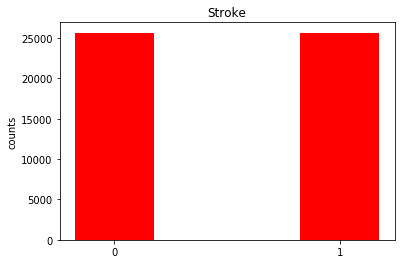

In [28]:
check_dataset_balance(spark_df)

#### We have successfully oversampled the class distribution

In [29]:
spark_df.printSchema()

root
 |-- age: long (nullable = true)
 |-- hypertension: long (nullable = true)
 |-- heart_disease: long (nullable = true)
 |-- avg_glucose_level: long (nullable = true)
 |-- bmi: long (nullable = true)
 |-- smoking_status_category: double (nullable = true)
 |-- gender_category: double (nullable = true)
 |-- stroke: long (nullable = true)



In [30]:
spark_df = spark_df.withColumn('stroke',spark_df['stroke'].cast(DoubleType()))
binarizer = Binarizer(inputCol='stroke',outputCol='label')
binarizer_df = binarizer.transform(spark_df)

In [31]:
binarizer_df.show()

+---+------------+-------------+-----------------+---+-----------------------+---------------+------+-----+
|age|hypertension|heart_disease|avg_glucose_level|bmi|smoking_status_category|gender_category|stroke|label|
+---+------------+-------------+-----------------+---+-----------------------+---------------+------+-----+
| 67|           1|            0|               75| 21|                    1.0|            0.0|   0.0|  0.0|
| 24|           0|            0|              142| 29|                    0.0|            0.0|   0.0|  0.0|
| 52|           0|            0|               82| 23|                    0.0|            0.0|   0.0|  0.0|
| 78|           0|            1|               81| 30|                    2.0|            1.0|   0.0|  0.0|
| 49|           0|            0|              104| 24|                    0.0|            1.0|   0.0|  0.0|
| 14|           0|            0|               65| 19|                    0.0|            1.0|   0.0|  0.0|
| 44|           0|          

In [32]:
assembler = VectorAssembler(inputCols=featureColumns,outputCol='features')
assembled_df = assembler.transform(binarizer_df)
assembled_df.show()

+---+------------+-------------+-----------------+---+-----------------------+---------------+------+-----+--------------------+
|age|hypertension|heart_disease|avg_glucose_level|bmi|smoking_status_category|gender_category|stroke|label|            features|
+---+------------+-------------+-----------------+---+-----------------------+---------------+------+-----+--------------------+
| 67|           1|            0|               75| 21|                    1.0|            0.0|   0.0|  0.0|[67.0,1.0,0.0,75....|
| 24|           0|            0|              142| 29|                    0.0|            0.0|   0.0|  0.0|(7,[0,3,4],[24.0,...|
| 52|           0|            0|               82| 23|                    0.0|            0.0|   0.0|  0.0|(7,[0,3,4],[52.0,...|
| 78|           0|            1|               81| 30|                    2.0|            1.0|   0.0|  0.0|[78.0,0.0,1.0,81....|
| 49|           0|            0|              104| 24|                    0.0|            1.0|   

In [33]:
( train_set ,test_set  ) = assembled_df.randomSplit([0.7,0.3],seed = 0.2)

In [34]:
print('Class Distribution:',train_set.groupBy('label').count().take(3))

Class Distribution: [Row(label=0.0, count=18030), Row(label=1.0, count=17992)]


In [35]:
rf = RandomForestClassifier()
rf_model = rf.fit(train_set)
preds = rf_model.transform(test_set)
preds.show(5)

+---+------------+-------------+-----------------+---+-----------------------+---------------+------+-----+--------------------+--------------------+--------------------+----------+
|age|hypertension|heart_disease|avg_glucose_level|bmi|smoking_status_category|gender_category|stroke|label|            features|       rawPrediction|         probability|prediction|
+---+------------+-------------+-----------------+---+-----------------------+---------------+------+-----+--------------------+--------------------+--------------------+----------+
| 10|           0|            0|               55| 26|                    0.0|            1.0|   0.0|  0.0|[10.0,0.0,0.0,55....|[18.6837105398873...|[0.93418552699436...|       0.0|
| 10|           0|            0|               58| 20|                    0.0|            0.0|   0.0|  0.0|(7,[0,3,4],[10.0,...|[18.8557368759587...|[0.94278684379793...|       0.0|
| 10|           0|            0|               61| 32|                    0.0|            

In [36]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator.evaluate(preds)

0.9475379750271369

In [37]:
accuracy = preds.filter(preds.label == preds.prediction).count() / float(test_set.count())
accuracy

0.8611981205951449

#### Now lets try with Pipeline

In [38]:
( pipe_train_set ,pipe_test_set  ) = df.select('age','hypertension','heart_disease','avg_glucose_level','bmi','smoking_status','gender','stroke').randomSplit([0.7,0.3],seed = 0.2)

In [39]:
label_string_indexer = StringIndexer(inputCol = 'stroke',outputCol= 'label' )
lr = LogisticRegression()
pipeline = Pipeline(stages=[smoke_indexer, \
                            gender_indexer, \
                            label_string_indexer, \
                            assembler,\
                            lr])
pipelineFit = pipeline.fit(pipe_train_set)


In [40]:
pipe_train_df = pipelineFit.transform(pipe_train_set)
pipe_test_df = pipelineFit.transform(pipe_test_set)


In [41]:
accuracy = pipe_test_df.filter(pipe_test_df.label == pipe_test_df.prediction).count() / float(pipe_test_set.count())
roc_auc = evaluator.evaluate(pipe_test_df)

In [42]:
print('Accuracy Score: {0:.4f} %'.format(accuracy*100))
print('ROC-AUC: {0:.4f} %'.format(roc_auc*100))

Accuracy Score: 97.9488 %
ROC-AUC: 85.1063 %


In [43]:
!git clone

fatal: You must specify a repository to clone.

usage: git clone [<options>] [--] <repo> [<dir>]

    -v, --verbose         be more verbose
    -q, --quiet           be more quiet
    --progress            force progress reporting
    -n, --no-checkout     don't create a checkout
    --bare                create a bare repository
    --mirror              create a mirror repository (implies bare)
    -l, --local           to clone from a local repository
    --no-hardlinks        don't use local hardlinks, always copy
    -s, --shared          setup as shared repository
    --recurse-submodules[=<pathspec>]
                          initialize submodules in the clone
    -j, --jobs <n>        number of submodules cloned in parallel
    --template <template-directory>
                          directory from which templates will be used
    --reference <repo>    reference repository
    --reference-if-able <repo>
                          reference repository
    --dissociate          u

In [44]:
!git clone https://github.com/subhasisj/python-projects/tree/master/Machine%20Learning%20Projects/PySpark%20ML

Cloning into 'PySpark%20ML'...
fatal: repository 'https://github.com/subhasisj/python-projects/tree/master/Machine%20Learning%20Projects/PySpark%20ML/' not found


In [45]:
!git clone https://github.com/subhasisj/python-projects.git

Cloning into 'python-projects'...
remote: Enumerating objects: 223, done.
remote: Counting objects: 100% (223/223), done.
remote: Compressing objects: 100% (164/164), done.
remote: Total 5015 (delta 115), reused 116 (delta 48), pack-reused 4792
Receiving objects: 100% (5015/5015), 183.79 MiB | 20.18 MiB/s, done.
Resolving deltas: 100% (282/282), done.
Checking out files: 100% (2472/2472), done.


In [48]:
!git commit -m "Execute notebooks"

fatal: not a git repository (or any of the parent directories): .git
